<a href="https://colab.research.google.com/github/joseflix/DocenciaUAB/blob/master/utils/TCX_Wahoo_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TCX bulk analyzer**

Analitzador de fitxers TCX, per treure gràfiques de sumaritzen el rendiment per a cada una de les rutes. És molt útil per fer seguiment de rutes virtuals que penjo a Strava (fetes amb Zwift, Rouvy, Bkool, utilitzant un Wahoo Kickr i monitor HR).

Els pasos són:

  * Decarregar els fitxers TCX des de Strava. Això es fa afegint */export_tcx* a la *URL* d'una ruta. Per exemple: https://www.strava.com/activities/3236335816/export_tcx
  * Posar tots els fitxers TCX en un directori de Google Drive. En el cas d'aquest exemple els meus fitxers TCX es troben a *Colab Notebooks/data/TCX_files*
  * Quan s'executa aquest Notebook, es monta el sistema de fitxers de Drive, i els fitxers apareixen sota '/content/drive/My Drive/....'. La primera vegada que s'executa, demana obrir una *url* i copiar un token per poder autoritzar l'ús. 
  * El Notebook mirarà tots els fitxers TCX que hi hagin en el directori i els analitzarà per proporcionar les estadístiques de les sessions: Kms fets, temps dedicats, cadència, monitor de cor, potència, velocitat...

J. Flix: v.1.0.

In [295]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import fromstring
from time import strptime, strftime
from optparse import OptionParser
import sys
import re
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

directory = '/content/drive/My Drive/Colab Notebooks/data/TCX_files'

Mounted at /content/drive


In [0]:
# Definició de funcions
# Adaptades de https://github.com/jhofman/fitnesshacks/blob/master/tcx.py

def findtext(e, name, default=None):
    """
    findtext
    helper function to find sub-element of e with given name and
    return text value
    returns default=None if sub-element isn't found
    """
    try:
        return e.find(name).text
    except:
        return default


def parsetcx_pd(tcx_file):
    """
    parsetcx
    parses tcx data, returning a list of all Trackpoints where each
    point is a tuple of 
      (activity, lap, timestamp, seconds, lat, long, alt, dist, heart, cad)
    xml is a string of tcx data
    """
    # set input and output streams
    istream = open(tcx_file,'r')

    # read xml contents
    xml = istream.read()

    # remove xml namespace (xmlns="...") to simplify finds
    # note: do this using ET._namespace_map instead?
    # see http://effbot.org/zone/element-namespaces.htm
    xml = re.sub('xmlns=".*?"','',xml)

    # parse xml
    tcx=fromstring(xml)

    activity = tcx.find('.//Activity').attrib['Sport']

    lapnum=1
    points=[]
    t_a = []
    lat_a = []
    lon_a = []
    ele_a = []
    dist_a = []
    hr_a = []
    cad_a = []
    speed_a = []
    pow_a = []
    t_a2 = []
#    t_a = lat_a = lon_a= ele_a = dist_a = hr_a = cad_a = speed_a = pow_a = t_a2 = []

    for lap in tcx.findall('.//Lap/'):
        for point in lap.findall('.//Trackpoint'):

            # time, both as string and in seconds GMT
            # note: adjust for timezone?
            timestamp2 = findtext(point, 'Time')
            timestamp = strftime('%Y-%m-%d %H:%M:%S', strptime(timestamp2, '%Y-%m-%dT%H:%M:%SZ'))
            if timestamp2:
                seconds = strftime('%s', strptime(timestamp2, '%Y-%m-%dT%H:%M:%SZ'))
            else:
                seconds = None

            # cummulative distance
            dist = findtext(point, 'DistanceMeters')
                
            # latitude and longitude
            position = point.find('Position')
            lat = findtext(position, 'LatitudeDegrees')
            long = findtext(position, 'LongitudeDegrees')

            # altitude
            alt = float(findtext(point, 'AltitudeMeters',0))
            
            # heart rate
            heart = float(findtext(point.find('HeartRateBpm'),'Value',0))

            # cadence
            cad = float(findtext(point, 'Cadence',0))

            # speed
            speed = 3.6*float(findtext(point.find('Extensions/TPX'),'Speed',0))
#            speed = float(findtext(point, 'Speed',0))

            # power
            power = float(findtext(point.find('Extensions/TPX'),'Watts',0))
#            power = float(findtext(point, 'Watts',0))

            # append to list of points
            points.append((activity,
                           lapnum,
                           timestamp, 
                           seconds, 
                           lat,
                           long,
                           alt,
                           dist,
                           heart,
                           cad,
                           speed,
                           power))
            t_a.append(timestamp)
            lat_a.append(lat)
            lon_a.append(long)
            ele_a.append(alt)
            dist_a.append(dist)
            hr_a.append(heart)
            cad_a.append(cad)
            speed_a.append(speed)
            pow_a.append(power)
        # next lap
        lapnum+=1

    df4=pd.DataFrame({'Latitude':lat_a, 'Longitude':lon_a, 'Altitude':ele_a, 'Distance':dist_a, 'HeartRate':hr_a, 'Cadence':cad_a, 'Speed':speed_a, 'Power':pow_a}, index=t_a)
    return df4

def parsetcx_summary_pd(tcx_file):
  total_t = total_d = 0.
  with open(tcx_file,'r') as fin:
    for line in fin:
      if 'Lap StartTime' in line:
        time = line.split('"')[1].split('T')[0] # In seconds
      if 'TotalTime' in line:
        total_t += float(line.split('>')[1].split('<')[0])/3600. # In hours
      if 'DistanceMeter' in line:
        total_d = float(line.split('>')[1].split('<')[0])/1000 # In meters
#      if 'MaximumSpeed' in line:
#        max_v = float(line.split('>')[1].split('<')[0])/1000. # In km/h

  df_tmp = parsetcx_pd(tcx_file)
  
  mean_hr = df_tmp['HeartRate'].mean()
  max_hr = df_tmp['HeartRate'].max()
  mean_cad = df_tmp['Cadence'].mean()
  max_cad = df_tmp['Cadence'].max()
  mean_pow = df_tmp['Power'].mean()
  max_pow = df_tmp['Power'].max()
  mean_v=float(df_tmp['Speed'].mean())
  max_v=float(df_tmp['Speed'].max())
  
  diff = [j-i for i, j in zip(df_tmp['Altitude'][:-1], df_tmp['Altitude'][1:])]
  ele_pos = np.cumsum([num for num in diff if num > 0.])[-1]
  ele_neg = np.cumsum([num for num in diff if num < 0.])[-1]

  c = pd.DataFrame({"T_Time (h)":total_t, "T_Distance (Km)":total_d, "Ele_Pos (m)":ele_pos, "Ele_Neg (m)":ele_neg, "V_mean (km/h)":mean_v, "V_max (km/h)":max_v, 
                    "HR_mean":mean_hr, "HR_max":max_hr, "Cad_mean":mean_cad, "Cad_max":max_cad,
                    "Power_mean":mean_pow, "Power_max":max_pow}, index={time})
  return c

#points = parsetcx_summary_pd(directory+"/Amy_s_Gran_Fondo_Run_to_the_finish.tcx")
#points
#points = get_TCX_summary_pd(directory+"/Amy_s_Gran_Fondo_Run_to_the_finish.tcx")
#print(points)

#    print(len(points))
    # print results
    # (activity, lap, timestamp, seconds, lat, long, alt, dist, heart, cad)
#    p = []
#    for point in points:
#      p.append(point[4])
#        print(delim.join(map(str, point))+'\n')
#    print(len(p))

#    (activity, lap, timestamp, seconds, lat, long, alt, dist, heart, cad)

In [0]:
# Definició de funcions (OLD! NO funcionen amb multiples LAPS)

def get_TCX_pd(tcx_file):
  tree = ET.parse(tcx_file)
  root = tree.getroot()
  for actt in root.iter('Activities'):
    print(actt.tag, actt.attrib)

  ns = {
      'tcx': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2',
  }
  tpxns = "http://www.garmin.com/xmlschemas/ActivityExtension/v2"

  t_a = []
  lat_a = []
  lon_a = []
  ele_a = []
  dist_a = []
  hr_a = []
  cad_a = []
  speed_a = []
  pow_a = []
  t_a2 = []

  t = root.find('./tcx:Activities/tcx:Activity/tcx:Lap', ns)
  for tr in t.iterfind('./tcx:Track', ns):
    for tmp in tr.iterfind('./tcx:Trackpoint/tcx:Time', ns):
      t_a2.append(strftime('%Y-%m-%d %H:%M:%S', strptime(tmp.text, '%Y-%m-%dT%H:%M:%SZ')))

  track = root.find('./tcx:Activities/tcx:Activity/tcx:Lap/tcx:Track', ns)
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:Time', ns):
    t_a.append(strftime('%Y-%m-%d %H:%M:%S', strptime(tmp.text, '%Y-%m-%dT%H:%M:%SZ')))
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:Position/tcx:LatitudeDegrees', ns):
    lat_a.append(float(tmp.text))
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:Position/tcx:LongitudeDegrees', ns):
    lon_a.append(float(tmp.text))
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:AltitudeMeters', ns):
    ele_a.append(float(tmp.text))
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:DistanceMeters', ns):
    dist_a.append(float(tmp.text))
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:HeartRateBpm/tcx:Value', ns):
    hr_a.append(float(tmp.text))
  for tmp in track.iterfind('./tcx:Trackpoint/tcx:Cadence', ns):
    cad_a.append(float(tmp.text))
  for tmp in track.iter("{%s}Speed"%tpxns):
    speed_a.append(3.6*float(tmp.text))
  for tmp in track.iter("{%s}Watts"%tpxns):
      pow_a.append(float(tmp.text))
    
  if (len(pow_a) < len(dist_a)):
    x = [0.] * (len(dist_a)-len(pow_a))
    pow_a = x + pow_a

  df4=pd.DataFrame({'Latitude':lat_a, 'Longitude':lon_a, 'Altitude':ele_a, 'Distance':dist_a, 'HeartRate':hr_a, 'Cadence':cad_a, 'Speed':speed_a, 'Power':pow_a}, index=t_a)

  diff = [j-i for i, j in zip(ele_a[:-1], ele_a[1:])]
  ele_pos = np.cumsum([num for num in diff if num > 0.])
  ele_neg = np.cumsum([num for num in diff if num < 0.])
  print(len(t_a),len(t_a2))
#  print(t_a[0], len(ele_a), ele_a[-1], dist_a[-1], len(lon_a))
#  print(ele_pos)
  return df4

def get_TCX_summary_pd(tcx_file):
  total_t = total_d = 0.
  with open(tcx_file,'r') as fin:
    for line in fin:
      if 'Lap StartTime' in line:
        time = line.split('"')[1].split('T')[0] # In seconds
      if 'TotalTime' in line:
        total_t += float(line.split('>')[1].split('<')[0])/3600. # In hours
      if 'DistanceMeter' in line:
        total_d = float(line.split('>')[1].split('<')[0])/1000 # In meters
#      if 'MaximumSpeed' in line:
#        max_v = float(line.split('>')[1].split('<')[0])/1000. # In km/h

  df_tmp = get_TCX_pd(tcx_file)

  mean_hr = df_tmp['HeartRate'].mean()
  max_hr = df_tmp['HeartRate'].max()
  mean_cad = df_tmp['Cadence'].mean()
  max_cad = df_tmp['Cadence'].max()
  mean_pow = df_tmp['Power'].mean()
  max_pow = df_tmp['Power'].max()
  mean_v=float(df_tmp['Speed'].mean())
  max_v=float(df_tmp['Speed'].max())

  c = pd.DataFrame({"T_Time (h)":total_t, "T_Distance (Km)":total_d, "V_mean (km/h)":mean_v, "V_max (km/h)":max_v, 
                    "HR_mean":mean_hr, "HR_max":max_hr, "Cad_mean":mean_cad, "Cad_max":max_cad,
                    "Power_mean":mean_pow, "Power_max":max_pow}, index={time})
  return c

In [300]:
# Bucle pels fitxers per extreu-re les dades

appended_data = []
appended_data2 = []

for filename in os.listdir(directory):
  print(filename)
  data = parsetcx_summary_pd(directory+"/"+filename)
  data2 = parsetcx_pd(directory+"/"+filename)
  appended_data.append(data)
  appended_data2.append(data2)

appended_data = pd.concat(appended_data)
appended_data.sort_index(inplace=True)

appended_data2 = pd.concat(appended_data2)
appended_data2.sort_index(inplace=True)

Amy_s_Gran_Fondo_Run_to_the_finish.tcx
Waregem_Ronse.tcx
Stage_1_Race_D_Tour_of_Watopia_2020.tcx
ZZRC_Approx_1_5_W_Kg_D_.tcx
Stage_5_Race_D_Tour_of_Watopia_2020.tcx
Stage_3_Race_D_Tour_of_Watopia_2020.tcx
Corse_Propriano_2_Confined_Virtual_YoMeQuedoEnCasa.tcx
Gregersh_let_V_le.tcx
Crit_City_Race_D_.tcx
Group_Ride_through_Marietta_GA.tcx


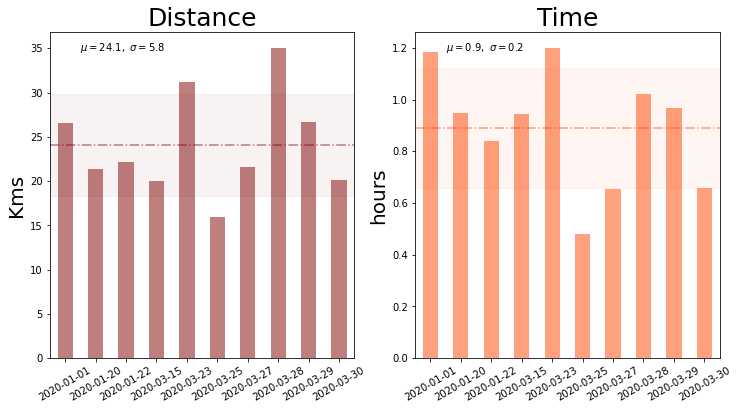

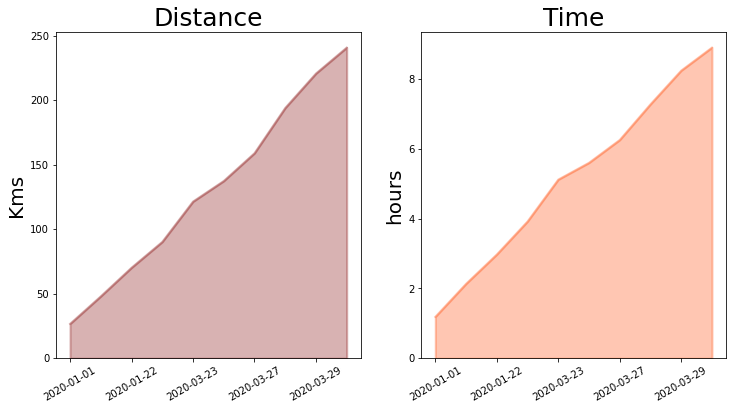

In [301]:
# Gràfiques distància i temps

from matplotlib.patches import Rectangle

###################################

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Distance", fontsize=25)
plt.ylabel("Kms", fontsize=20)
ax = appended_data['T_Distance (Km)'].plot(kind="bar",color='maroon', alpha=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.text(.5, .99*appended_data['T_Distance (Km)'].max(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data['T_Distance (Km)'].mean(),appended_data['T_Distance (Km)'].std()))
plt.hlines(appended_data['T_Distance (Km)'].mean(),-0.5,len(appended_data['T_Distance (Km)']),color='maroon', linestyles='dashdot', alpha=0.5)
rect = Rectangle((-0.5,appended_data['T_Distance (Km)'].mean()-appended_data['T_Distance (Km)'].std()), len(appended_data['T_Distance (Km)']), 2.*appended_data['T_Distance (Km)'].std(),linewidth=1,edgecolor='maroon',facecolor='maroon',alpha=0.05)
ax.add_patch(rect)

plt.subplot(122)
plt.title("Time", fontsize=25)
plt.ylabel("hours", fontsize=20)
ax = appended_data['T_Time (h)'].plot(kind="bar",color='orangered', alpha=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.text(.5, .99*appended_data['T_Time (h)'].max(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data['T_Time (h)'].mean(),appended_data['T_Time (h)'].std()))
plt.hlines(appended_data['T_Time (h)'].mean(),-0.5,len(appended_data['T_Time (h)']),color='orangered', linestyles='dashdot', alpha=0.5)
rect = Rectangle((-0.5,appended_data['T_Time (h)'].mean()-appended_data['T_Time (h)'].std()), len(appended_data['T_Time (h)']), 2.*appended_data['T_Time (h)'].std(),linewidth=1,edgecolor='orangered',facecolor='orangered',alpha=0.05)
ax.add_patch(rect)
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Distance", fontsize=25)
plt.ylabel("Kms", fontsize=20)
ax = appended_data['T_Distance (Km)'].cumsum().plot(kind="area", lw=2, color='maroon', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

plt.subplot(122)
plt.title("Time", fontsize=25)
plt.ylabel("hours", fontsize=20)
ax = appended_data['T_Time (h)'].cumsum().plot(kind="area", lw=2, color='orangered', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1282: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


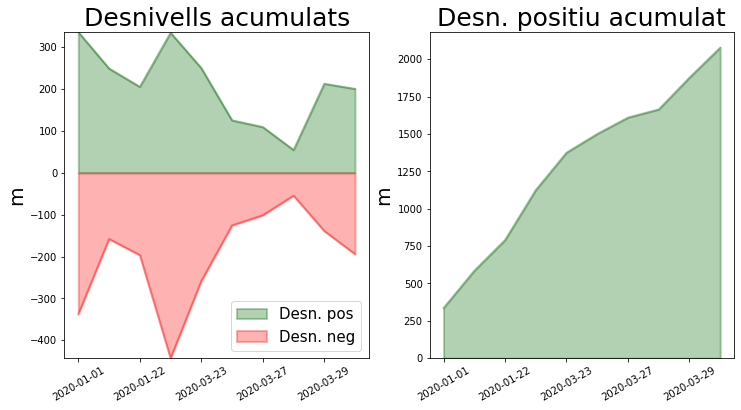

In [360]:
# Gràfiques Desnivells de pujada i baixades acumulats

###############################

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Desnivells acumulats", fontsize=25)
plt.ylabel("m", fontsize=20)
ax = appended_data['Ele_Pos (m)'].plot(kind="area", lw=2, color='darkgreen', alpha=0.3, label="Desn. pos")
appended_data['Ele_Neg (m)'].plot(kind="area", lw=2, color='red', alpha=0.3, label="Desn. neg")
plt.ylim(appended_data['Ele_Neg (m)'].min(),appended_data['Ele_Pos (m)'].max())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.legend(loc='best', fontsize=15)
#plt.text(.5, 1.05*appended_data2['Speed'].mean(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data2['Speed'].mean(),appended_data2['Speed'].std()),color='olive')
#plt.hlines(appended_data2['Speed'].mean(),-0.5,len(appended_data['V_mean (km/h)']),color='olive', linestyles='dashdot', alpha=0.5)
#rect = Rectangle((-0.5,appended_data2['Speed'].mean()-appended_data2['Speed'].std()), len(appended_data['V_mean (km/h)']), 2.*appended_data2['Speed'].std(),linewidth=1,edgecolor='olive',facecolor='olive',alpha=0.05)
#ax.add_patch(rect)


plt.subplot(122)
plt.title("Desn. positiu acumulat", fontsize=25)
plt.ylabel("m", fontsize=20)
ax = appended_data['Ele_Pos (m)'].cumsum().plot(kind="area", lw=2, color='darkgreen', alpha=0.3)
#plt.yscale("log")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.show()

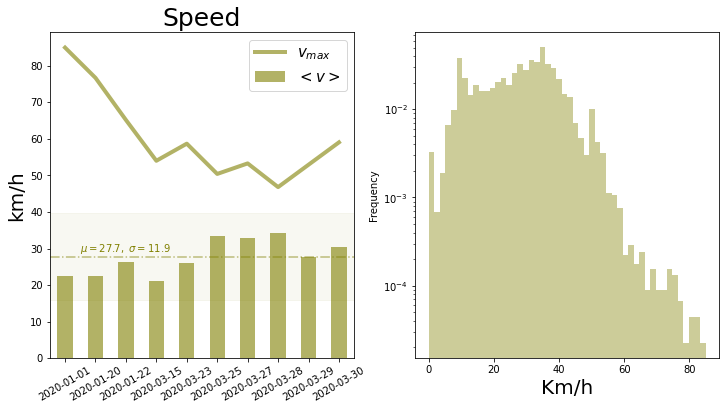

In [302]:
# Gràfiques Velocitat

###############################

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Speed", fontsize=25)
plt.ylabel("km/h", fontsize=20)
ax = appended_data['V_mean (km/h)'].plot(kind="bar",color='olive', label='$<v>$', alpha=0.6)
appended_data['V_max (km/h)'].plot(ax = ax, kind="line",color='olive', lw=4, label='$v_{max}$', alpha=0.6)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.legend(loc='best', fontsize=15)
plt.text(.5, 1.05*appended_data2['Speed'].mean(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data2['Speed'].mean(),appended_data2['Speed'].std()),color='olive')
plt.hlines(appended_data2['Speed'].mean(),-0.5,len(appended_data['V_mean (km/h)']),color='olive', linestyles='dashdot', alpha=0.5)
rect = Rectangle((-0.5,appended_data2['Speed'].mean()-appended_data2['Speed'].std()), len(appended_data['V_mean (km/h)']), 2.*appended_data2['Speed'].std(),linewidth=1,edgecolor='olive',facecolor='olive',alpha=0.05)
ax.add_patch(rect)


plt.subplot(122)
appended_data2['Speed'].plot(kind="hist", bins=50, density=True, color='olive', alpha=0.4)
plt.yscale("log")
plt.xlabel("Km/h", fontsize=20)
plt.show()

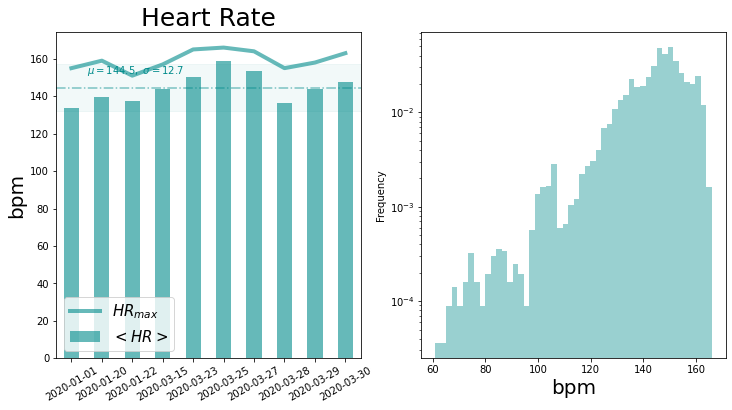

In [303]:
# Gràfiques Monitor de Cor

###############################

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.title("Heart Rate", fontsize=25)
plt.ylabel("bpm", fontsize=20)
ax = appended_data['HR_mean'].plot(kind="bar",color='darkcyan', label='$<HR>$', alpha=0.6)
appended_data['HR_max'].plot(ax = ax, kind="line",color='darkcyan', lw=4, label='$HR_{max}$', alpha=0.6)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.legend(loc='best', fontsize=15)
plt.text(.5, 1.05*appended_data2['HeartRate'].mean(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data2['HeartRate'].mean(),appended_data2['HeartRate'].std()),color='darkcyan')
plt.hlines(appended_data2['HeartRate'].mean(),-0.5,len(appended_data['HR_mean']),color='darkcyan', linestyles='dashdot', alpha=0.5)
rect = Rectangle((-0.5,appended_data2['HeartRate'].mean()-appended_data2['HeartRate'].std()), len(appended_data['HR_mean']), 2.*appended_data2['HeartRate'].std(),linewidth=1,edgecolor='darkcyan',facecolor='darkcyan',alpha=0.05)
ax.add_patch(rect)

plt.subplot(122)
appended_data2['HeartRate'].plot(kind="hist", bins=50, density=True, color='darkcyan', alpha=0.4)
plt.yscale("log")
plt.xlabel("bpm", fontsize=20)
plt.show()

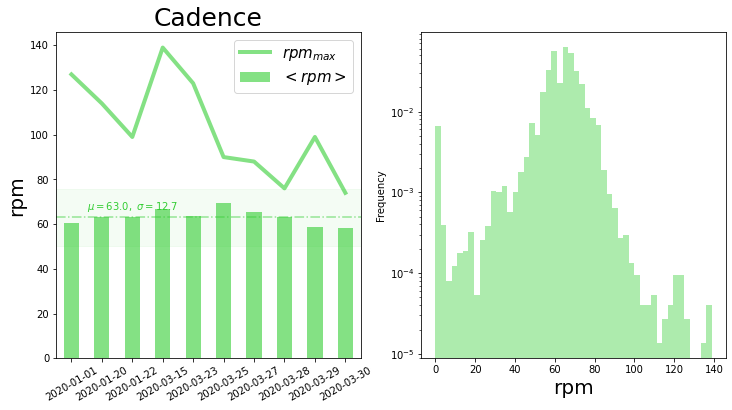

In [304]:
# Gràfiques Cadència

###############################

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.title("Cadence", fontsize=25)
plt.ylabel("rpm", fontsize=20)
ax = appended_data['Cad_mean'].plot(kind="bar",color='limegreen', label='$<rpm>$', alpha=0.6)
appended_data['Cad_max'].plot(ax = ax, kind="line",color='limegreen', lw=4, label='$rpm_{max}$', alpha=0.6)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.legend(loc='best', fontsize=15)
plt.text(.5, 1.05*appended_data2['Cadence'].mean(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data2['Cadence'].mean(),appended_data2['Cadence'].std()),color='limegreen')
plt.hlines(appended_data2['Cadence'].mean(),-0.5,len(appended_data['Cad_mean']),color='limegreen', linestyles='dashdot', alpha=0.5)
rect = Rectangle((-0.5,appended_data2['Cadence'].mean()-appended_data2['Cadence'].std()), len(appended_data['Cad_mean']), 2.*appended_data2['Cadence'].std(),linewidth=1,edgecolor='limegreen',facecolor='limegreen',alpha=0.05)
ax.add_patch(rect)

plt.subplot(122)
appended_data2['Cadence'].plot(kind="hist", bins=50, density=True, color='limegreen', alpha=0.4)
plt.yscale("log")
plt.xlabel("rpm", fontsize=20)
plt.show()

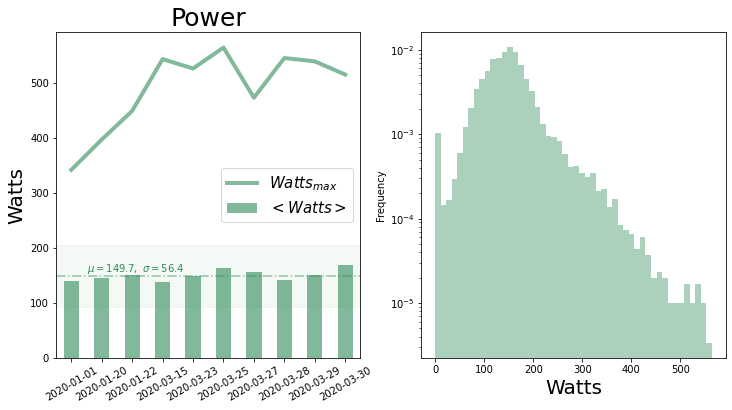

In [305]:
# Gràfiques Potència

###############################

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.title("Power", fontsize=25)
plt.ylabel("Watts", fontsize=20)
ax = appended_data['Power_mean'].plot(kind="bar",color='seagreen', label='$<Watts>$', alpha=0.6)
appended_data['Power_max'].plot(ax = ax, kind="line",color='seagreen', lw=4, label='$Watts_{max}$', alpha=0.6)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.legend(loc='best', fontsize=15)
plt.text(.5, 1.05*appended_data2['Power'].mean(), r'$\mu={:5.1f},\ \sigma={:5.1f}$'.format(appended_data2['Power'].mean(),appended_data2['Power'].std()),color='seagreen')
plt.hlines(appended_data2['Power'].mean(),-0.5,len(appended_data['Power_mean']),color='seagreen', linestyles='dashdot', alpha=0.5)
rect = Rectangle((-0.5,appended_data2['Power'].mean()-appended_data2['Power'].std()), len(appended_data['Power_mean']), 2.*appended_data2['Power'].std(),linewidth=1,edgecolor='seagreen',facecolor='seagreen',alpha=0.05)
ax.add_patch(rect)

plt.subplot(122)
appended_data2['Power'].plot(kind="hist", bins=50, density=True, color='seagreen', alpha=0.4)
plt.yscale("log")
plt.xlabel("Watts", fontsize=20)
plt.show()

###############################